# Problem 3

In [1]:
import numpy as np
import stan
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

import nest_asyncio

nest_asyncio.apply()

In [231]:
stan_code = """
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N, K] x;
  vector[N] y;
}

parameters {
  real alpha;
  vector[K] beta;
  real<lower=0> sigma2;
}

transformed parameters {
  real<lower=0> sigma;
  sigma = sqrt(sigma2);
}

model {
  // Priors
  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  sigma2 ~ inv_gamma(1, 10);

  // Likelihood
  y ~ normal(alpha + x * beta, sigma);
}
"""

In [230]:
# get data from insurance.csv
data = pd.read_csv('./insurance.csv')

# split the data into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_size = len(train_data)
test_size = len(test_data)

# split train and test into x and y while standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_y = train_data['charges'].values
train_y = (train_y - train_y.mean()) / train_y.std()
train_x = scaler.fit_transform(train_data[['bmi', 'age', 'children']].values)

test_y = test_data['charges'].values
test_y = (test_y - test_y.mean()) / test_y.std()
test_x = scaler.fit_transform(test_data[['bmi', 'age', 'children']].values)

In [232]:
# Prepare data for Stan
data_dict = {
    'N': train_size,
    'K': 3,
    'x': train_x,
    'y': train_y
}

# Compile and sample with Stan
model = stan.build(stan_code, data=data_dict)
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:  11% (900/8000)
Sampling:  36% (2900/8000)
Sampling:  61% (4900/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_uw7nskad/model_zsqlr3o7.stan', line 27, column 2 to column 38)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leap

In [233]:
# Calculate posterior statistics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.029,-0.056,0.054,0.000,0.0,4707.0,3141.0,1.0
beta[0],0.167,0.029,0.111,0.218,0.000,0.0,5069.0,3229.0,1.0
beta[1],0.258,0.029,0.202,0.310,0.000,0.0,4838.0,2975.0,1.0
beta[2],0.057,0.030,0.004,0.115,0.000,0.0,5170.0,3384.0,1.0
sigma2,0.913,0.040,0.838,0.985,0.001,0.0,4912.0,3068.0,1.0
sigma,0.955,0.021,0.916,0.993,0.000,0.0,4912.0,3068.0,1.0


/home/mercal/anaconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


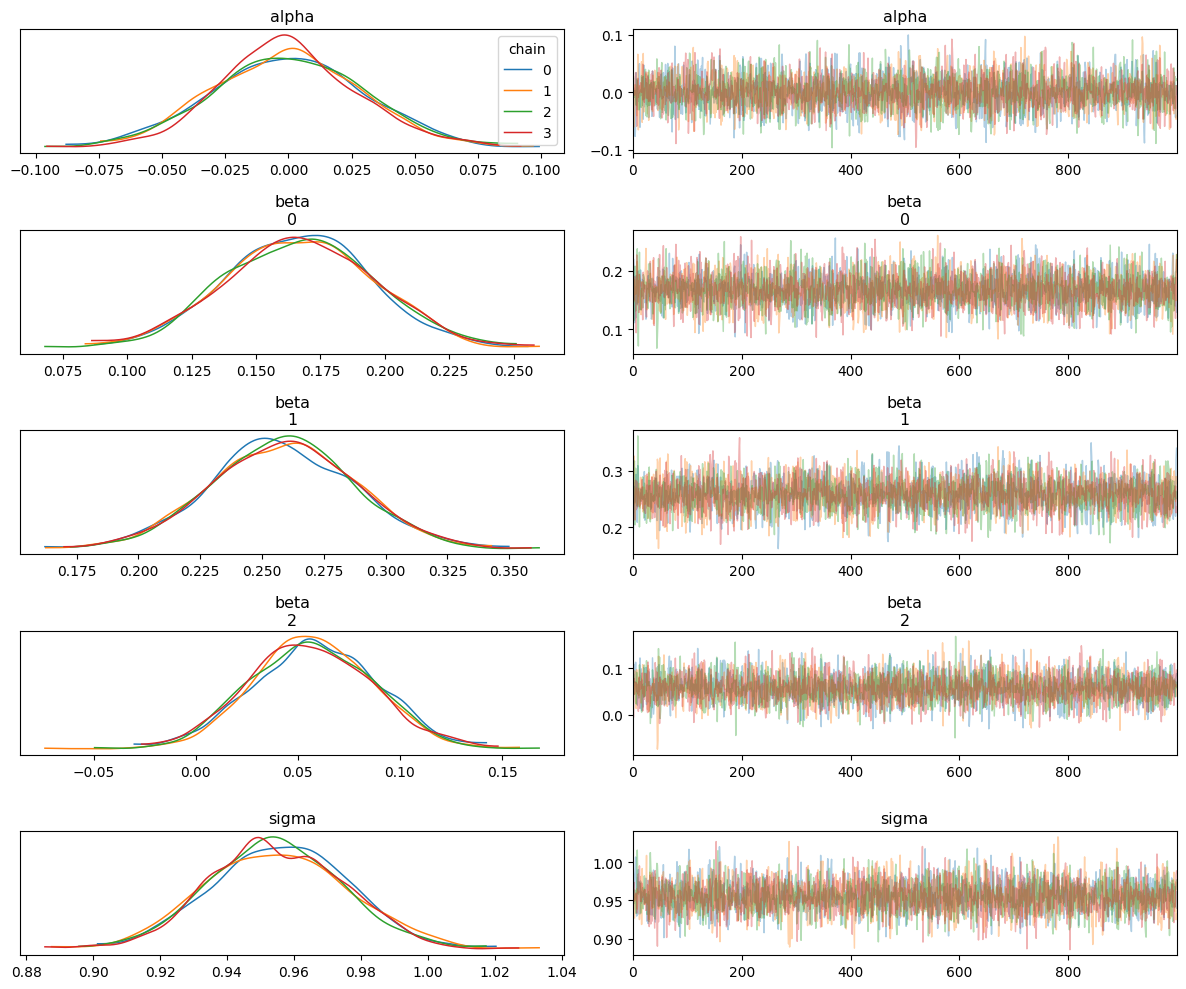

In [221]:
az.plot_trace(fit, var_names=['alpha', 'beta', 'sigma'], compact=False, legend=True)
plt.tight_layout()

Looking at all the graphs, each chain is indistiguishable and none have a drift. r_hat is 1.0 for each and effective sample size is large. Sigma includes 1 within 3 standard deviations which is the std of the standardized data.  
Based off these values, age, which corresponds to beta[1], is the best predictor of insurance charges since it's beta is the largest.